# VISUM Interpretability Hands-On Session  

## Part 2 - Medical Image Analysis 

### Dataset

In the second part of this class, we will be dealing with a medical dataset - the **NIH Chest X-Ray dataset** ( https://arxiv.org/abs/1705.02315 ). This dataset is composed of 108,948 frontal-view X-ray images of 32,717 unique patients, and **eight disease image labels** (where each image can have multiple labels).   

![alt text](aux_imgs/image_labels.png "Title")

Taking into consideration time and memory constrainsts, for this hands-on session, we will only consider a **small subset** of the data. Moreover, we will focus on the detection of **Cardiomegaly** (one of the eight labels available).

![alt text](aux_imgs/cardiomegaly.png "Title")

### Deep Neural Network Architecture 

To solve the **classification task** previously described, we will use a Deep Neural Network mainly based on the well known **VGG16 architecture** (https://arxiv.org/pdf/1409.1556.pdf). The implementation of the network will be done using **Keras** (https://keras.io/). 

In [1]:
import pickle 
import numpy as np 
import matplotlib.pyplot as plt 
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from keras.optimizers import adam
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
def vgg16(inputs):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', \
               name='block1_conv1')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', \
               name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', \
               name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', \
               name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', \
               name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', \
               name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', \
               name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    return x

In addition to the VGG16 (without the top/dense layers) we will **add** some **more convolution and max pooling layers**. 

In [3]:
def extra_conv(inputs):
    x = Conv2D(512, (3, 3), activation='relu', padding='valid', \
               name='block6_conv1')(inputs)
    x = Conv2D(512, (3, 3), activation='relu', padding='valid', \
               name='block6_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='valid', \
               name='block6_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block6_pool')(x)
    
    return x

Finally, we will need a set of **dense layers** to compute the **probabilities** for each class. Furthermore, two **Dropout** layers are also added for **regularization** purposes. 

In [4]:
def clf_from_fts(inputs): 
    flat = Flatten()(inputs)
    dense1 = Dense(100, activation='relu', name='first_dense')(flat)
    dense1 = Dropout(0.1, name='dropout_1')(dense1)
    dense1 = Dense(20, activation='relu', name='second_dense')(dense1)
    dense1 = Dropout(0.1, name='dropout_2')(dense1)
    dense1 = Dense(2, activation='softmax', name='clf')(dense1)
    
    return dense1

### Pre-processing of Data

The original image dimensions of the dataset are 1024x1024. However, for time and complexity reasons, we will be working with half of that, i.e., **512x512**. It is also important to mention that the images are in **grayscale**. 

<IPython.core.display.Javascript object>


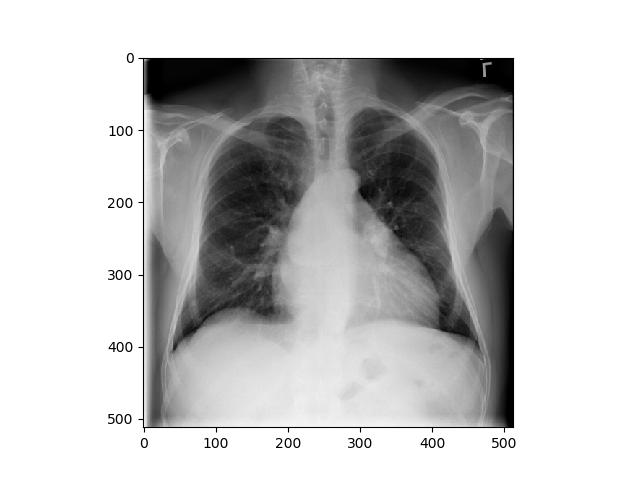

In [5]:
%matplotlib notebook

with open("NIH_Data/X_400.pickle",'rb') as fp: 
        X = pickle.load(fp)
X = np.array(X, dtype='float') 

plt.imshow(X[0], cmap='gray')
plt.show()

Nonetheless, as we want to use the VGG16 and **initialize** it with the **weights** resultant of its **pre-training** in **ImageNet** ( http://www.image-net.org/ ), we have to turn the **grayscale/1-channel image** into a **3-channel image**. Moreover, images should be pre-processed in the same way as they were for the pre-training with ImageNet.

In [6]:
X = np.reshape(X, (-1, 512, 512, 1))
X = np.concatenate([X, X, X], axis=3)
print('Shape of X: ', X.shape)

X = preprocess_input(X) # pre-process for VGG16
print('X max: ', np.max(X))

Shape of X:  (400, 512, 512, 3)
X max:  151.061


For the **labels**, we will use **one-hot encoding**:

In [7]:
with open("NIH_Data/y_400.pickle",'rb') as fp: 
        y = pickle.load(fp)
y = np.array(y)
    
print('Shape of y: ', y.shape)
labels = to_categorical(y)

Shape of y:  (400,)


### Define Keras Model 

Input layer: 

In [8]:
inputs = Input((512, 512, 3), name='input_for_chest')

**VGG16** Model to save pre-trained weights: 

In [9]:
conv_base = VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet') 
fts_vgg = conv_base(inputs)
model_vgg = Model(inputs=inputs, outputs=fts_vgg) # define a model 
model_vgg.summary() # print model
model_vgg.save_weights('Models/vgg_imagenet.hdf5') # to save pre-trained weights

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_for_chest (InputLayer) (None, 512, 512, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


Define Model: 

In [10]:
vgg_fts = vgg16(inputs) 
fts = extra_conv(vgg_fts)
clf = clf_from_fts(fts) 

model = Model(inputs=inputs, outputs=clf)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_for_chest (InputLayer) (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

Load weights into model:

In [11]:
model.load_weights('Models/vgg_imagenet.hdf5', by_name=True)

Define optimizer and loss function: 

In [12]:
model.compile(optimizer=adam(lr=0.00001), loss=categorical_crossentropy, metrics=['acc'])

### Training Process

**Split data** into training and validation: 

In [13]:
sk = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_idx, validation_idx in sk.split(X, y): 
    X_train, X_validation = X[train_idx], X[validation_idx]
    y_train, y_validation = labels[train_idx], labels[validation_idx]

Dataset is highly **imbalanced**. Therefore, we will consider different costs to the misclassification of each class: 

In [14]:
gnd = np.argmax(y_train, axis=1)
gnd = gnd.tolist()

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(gnd), gnd)
print(class_weights)  

[0.56761006 4.19767442]


Generator for **data augmentation** - in this example we are only using horizontal flips. 

In [15]:
def my_generator_final(X, y, minibatch_size):
    keras_datagen = ImageDataGenerator(rotation_range=0,
                                       zoom_range=0,
                                       width_shift_range=0,
                                       height_shift_range=0,
                                       horizontal_flip=True,
                                       )
    X = np.array(X)
    
    N = len(X)
    while True:
        indices = np.random.choice(N, N, False)
        
        for i in range(N // minibatch_size):
            batch_indices = indices[i*minibatch_size:(i+1)*minibatch_size]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]
            

            batch_X, batch_y = next(keras_datagen.flow(batch_X, \
                                              batch_y, \
                                              batch_size=minibatch_size, \
                                              shuffle=False))
            
            yield (batch_X, batch_y)

Define callback to save model that behaves better regarding the validation data:

In [16]:
checkpoint = ModelCheckpoint('Models/NIH.hdf5', monitor='val_acc', save_best_only=True, verbose=True)

Train the Model. 

**Note**: you can skip the next step because there is a model already trained. Nonetheless, if you want, after finishing this notebook you can build your own model and use again the interpretability methods presented. However, it should respect a time restriction of about 20 minutes for training.

In [ ]:
model.fit_generator(my_generator_final(X_train, y_train, 2), steps_per_epoch = X_train.shape[0]/2, epochs=50,\
                verbose=2, callbacks=[checkpoint], class_weight=class_weights, validation_data=(X_validation, y_validation))  

Load best performing model:

In [17]:
model = load_model('Models/NIH.hdf5')

Computing training performance:

In [18]:
label = np.argmax(y_train, axis=1)

pred = model.predict(X_train, batch_size=1)
pred = np.argmax(pred, axis=1)

print(accuracy_score(label, pred))

0.9113573407202216


Select image to investigate - select one in which prediction and ground-truth agree with Cardiomegaly.

In [19]:
index = 0 

for i in range(X_train.shape[0]): 
    if(label[i]==1 and pred[i]==1): 
        index = i
        break 
        
x = X_train[index]
x = np.reshape(x, (1, 512, 512, 3))

### Investigate Model using iNNvestigate toolbox 

In [2]:
from innvestigate.utils import model_wo_softmax
from innvestigate import create_analyzer

In [12]:
def plot_interpretation(img): 
    img = img.sum(axis=np.argmax(np.asarray(img.shape) == 3))
    img /= np.max(np.abs(img))
    img = np.reshape(img, (512, 512))

    plt.imshow(img, cmap='plasma')
    plt.show()  

In [22]:
model_without_softmax = model_wo_softmax(model)

Now, to use the **interpretability methods** that do not require training:
- **Gradient** 
- **SmoothGrad** 
- **Deconvnet** 
- **Guided Backprop** 
- **Deep Taylor** 
- **Input * Gradient**
- **Integrated Gradients** 
- **LRP** (LRP-Z, LRP-Epsilon, LRP-PresetAFlat, LRP-PresetBFlat)

#### - Gradient

In [23]:
analyzer = create_analyzer("gradient", model_without_softmax)  
grad_img = analyzer.analyze(x)

Process image to plot:

<IPython.core.display.Javascript object>


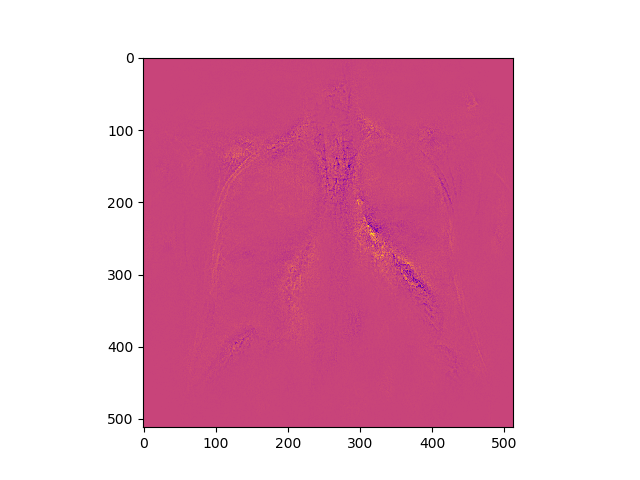

In [24]:
%matplotlib notebook

plot_interpretation(grad_img)

#### - SmoothGrad
Paper link: https://arxiv.org/abs/1706.03825.

In [25]:
analyzer = create_analyzer("smoothgrad", model_without_softmax, **{"augment_by_n": 2})  
smooth_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


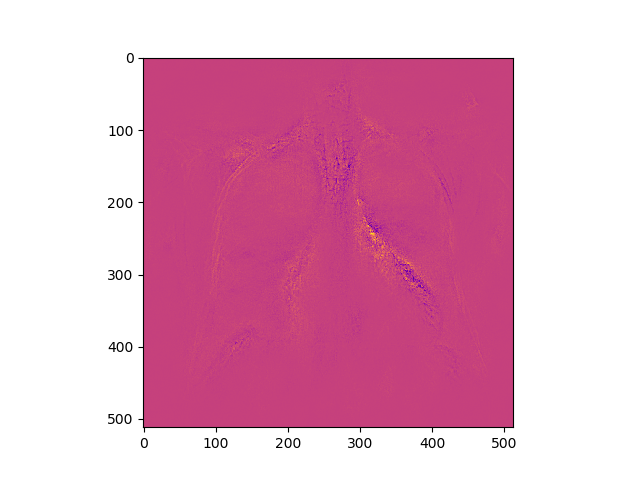

In [26]:
%matplotlib notebook

plot_interpretation(smooth_img)

#### - DeconvNet
Paper link: https://arxiv.org/abs/1311.2901.

In [27]:
analyzer = create_analyzer("deconvnet", model_without_softmax)  
deconv_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


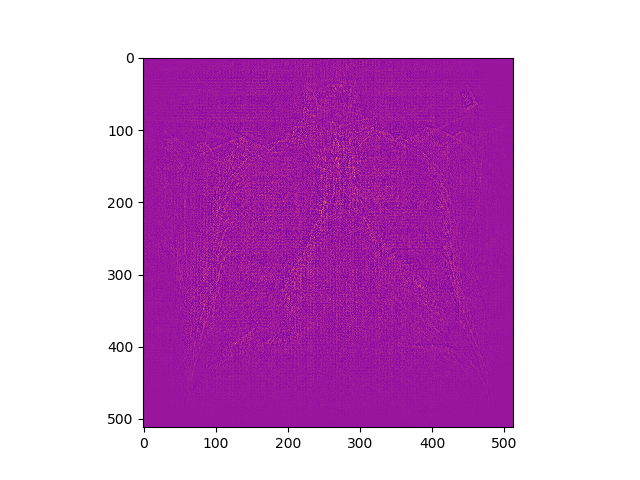

In [28]:
%matplotlib notebook

plot_interpretation(deconv_img)

#### - Guided-backpropagation
Paper link: https://arxiv.org/abs/1412.6806

In [29]:
analyzer = create_analyzer("guided_backprop", model_without_softmax)  
guided_backprop_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


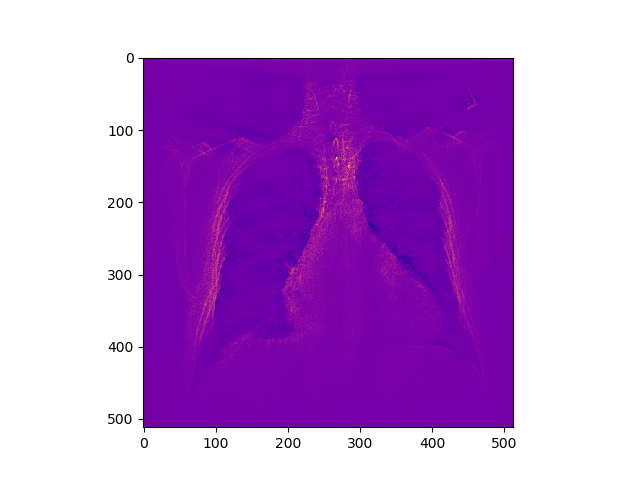

In [30]:
%matplotlib notebook

plot_interpretation(guided_backprop_img)

#### - Deep Taylor 
Paper link: https://arxiv.org/abs/1512.02479

In [31]:
analyzer = create_analyzer("deep_taylor", model_without_softmax)  
deep_taylor_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


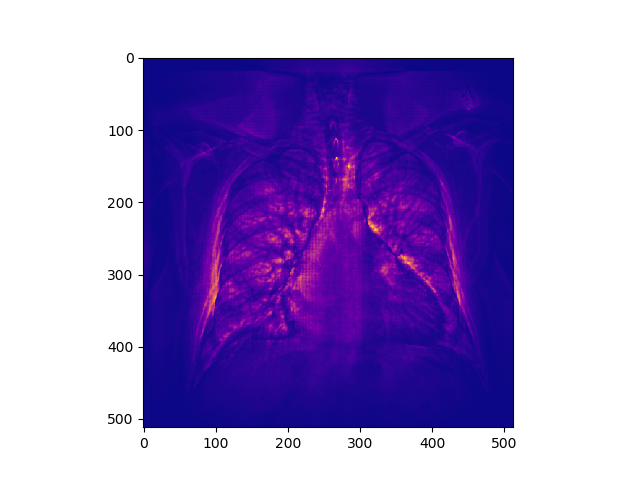

In [32]:
%matplotlib notebook

plot_interpretation(deep_taylor_img)

#### - Input * Gradient

In [33]:
analyzer = create_analyzer("input_t_gradient", model_without_softmax)  
input_t_gradient_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


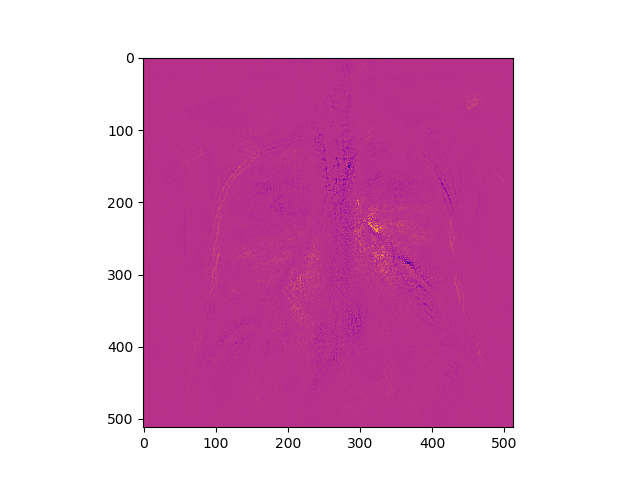

In [34]:
%matplotlib notebook

plot_interpretation(input_t_gradient_img)

#### - Integrated Gradients
Paper link: https://arxiv.org/abs/1703.01365. 

In [35]:
analyzer = create_analyzer("integrated_gradients", model_without_softmax, **{"steps":2})  
integrated_grad_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


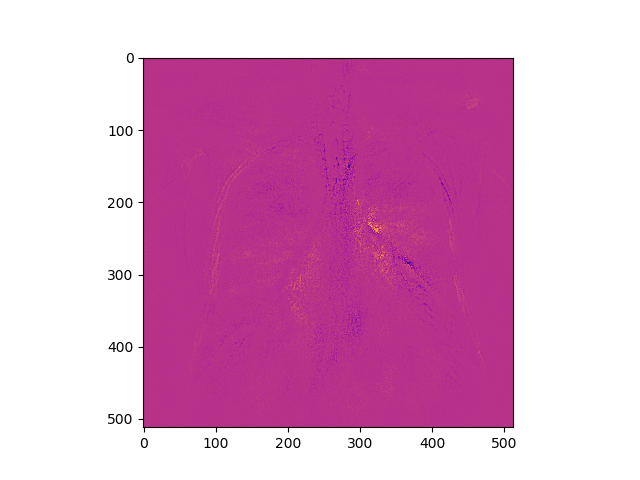

In [36]:
%matplotlib notebook

plot_interpretation(integrated_grad_img)

#### - LRP with different rules 
Paper link: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140.

#### LRP (z)

In [37]:
analyzer = create_analyzer("lrp.z", model_without_softmax)  
lrp_z_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


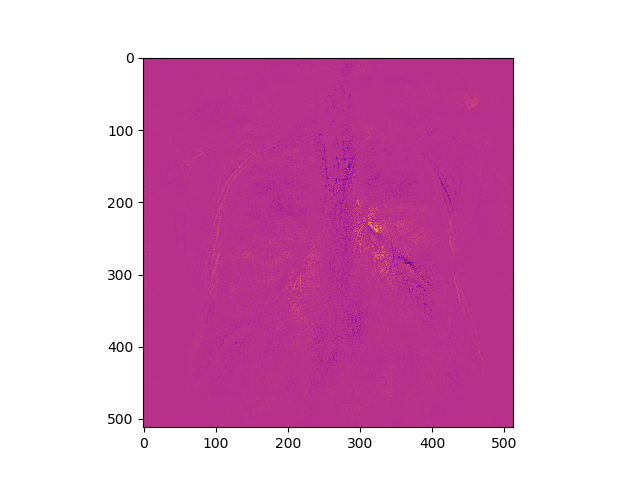

In [38]:
%matplotlib notebook

plot_interpretation(lrp_z_img)

#### LRP (epsilon)

In [39]:
analyzer = create_analyzer("lrp.epsilon", model_without_softmax)  
lr_epsilon_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


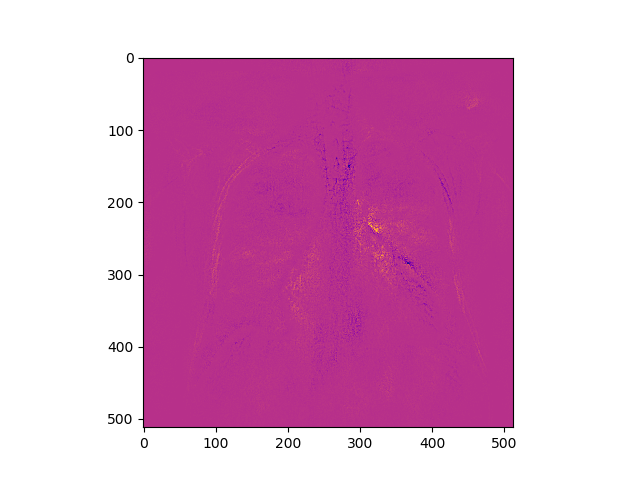

In [40]:
%matplotlib notebook

plot_interpretation(lr_epsilon_img)

#### LRP (sequential_preset_a_flat)

In [41]:
analyzer = create_analyzer("lrp.sequential_preset_a_flat", model_without_softmax)  
lrp_flat_a_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


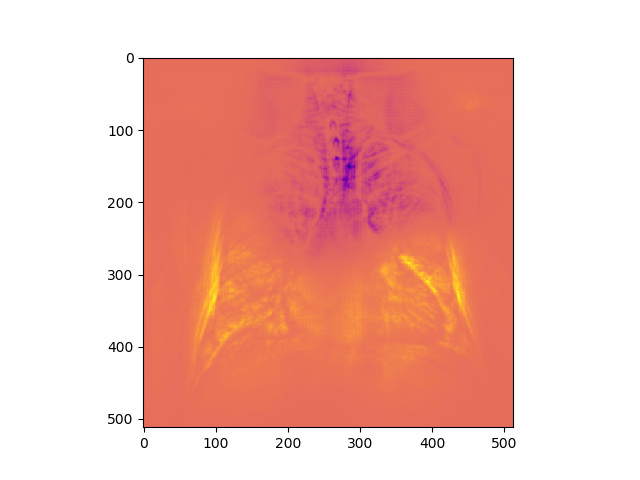

In [42]:
%matplotlib notebook

plot_interpretation(lrp_flat_a_img)

#### LRP (sequential_preset_b_flat)

In [43]:
analyzer = create_analyzer("lrp.sequential_preset_b_flat", model_without_softmax)  
lrp_flat_b_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


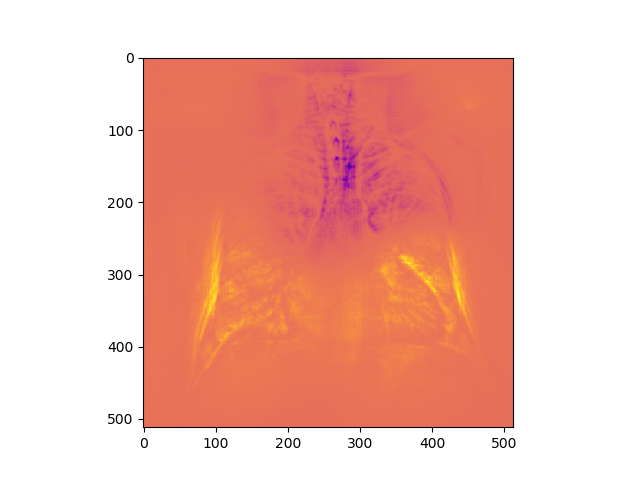

In [44]:
%matplotlib notebook

plot_interpretation(lrp_flat_b_img)

In both methods presented above, warm colors mean positive contribution to the decision and cold colors mean negative contribution to the decision, which is in accordance with the localization of Cardiomegaly.

To use the **interpretability methods** that require **training**: 
- PatternNet 
- PatternAttribution

Paper link: https://arxiv.org/abs/1705.05598.

![alt text](aux_imgs/pattern_net.png "Title")

#### - PatterNet

In [45]:
analyzer = create_analyzer("pattern.net", model_without_softmax)
analyzer.fit(X_train, batch_size=1)
pattern_net_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


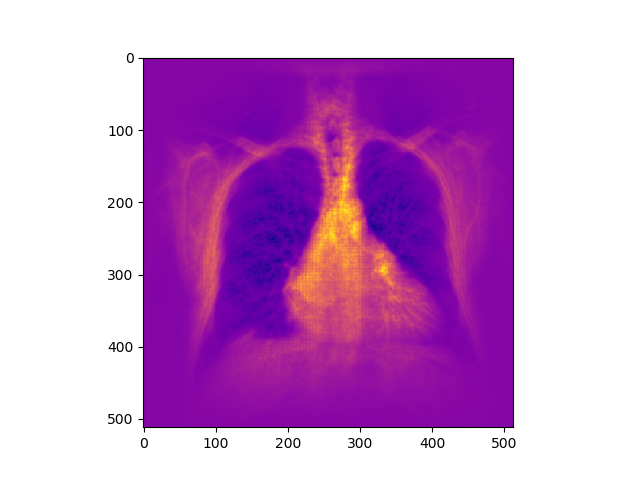

In [46]:
%matplotlib notebook

plot_interpretation(pattern_net_img)

#### - PatternAttribution

In [47]:
analyzer = create_analyzer("pattern.attribution", model_without_softmax)
analyzer.fit(X_train, batch_size=1)
pattern_attribution_img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


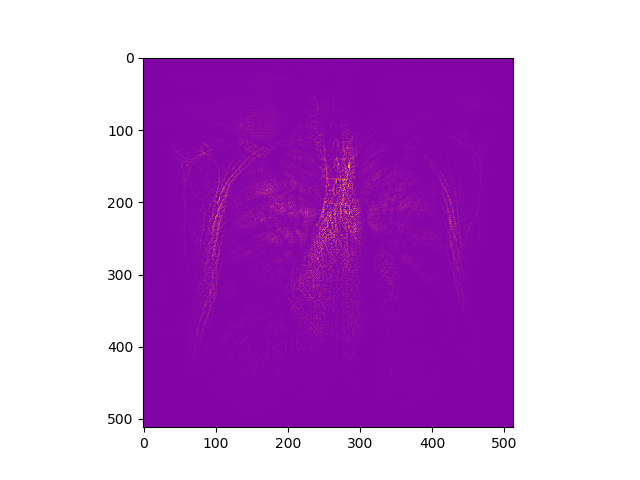

In [48]:
%matplotlib notebook

plot_interpretation(pattern_attribution_img)

Check case where image belongs to patient with Cardiomegaly but network predicts the opposite. 

In [49]:
index_err = 0 

for i in range(X_train.shape[0]): 
    if(label[i]==1 and pred[i]==0): 
        index_rr = i
        break 
        
x_error = X_train[index_err]
x_error = np.reshape(x_error, (1, 512, 512, 3))

#### - Guided-Backpropagation
Compare with the case where image was correctly classified. 

In [50]:
analyzer = create_analyzer("guided_backprop", model_without_softmax)  
guided_backprop_img_error = analyzer.analyze(x_error)

<IPython.core.display.Javascript object>


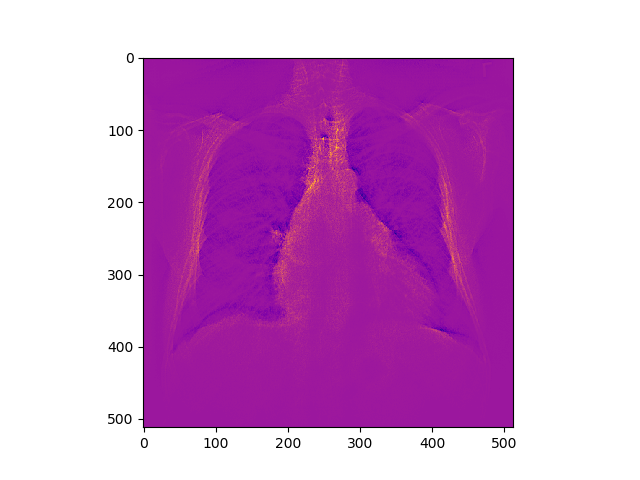

In [51]:
%matplotlib notebook

plot_interpretation(guided_backprop_img_error)

#### - LRP (sequential_preset_b_flat)
Compare again with the case where image was correctly classified. 

In [52]:
analyzer = create_analyzer("lrp.sequential_preset_b_flat", model_without_softmax)  
lrp_b_flat_img_error = analyzer.analyze(x_error)

<IPython.core.display.Javascript object>


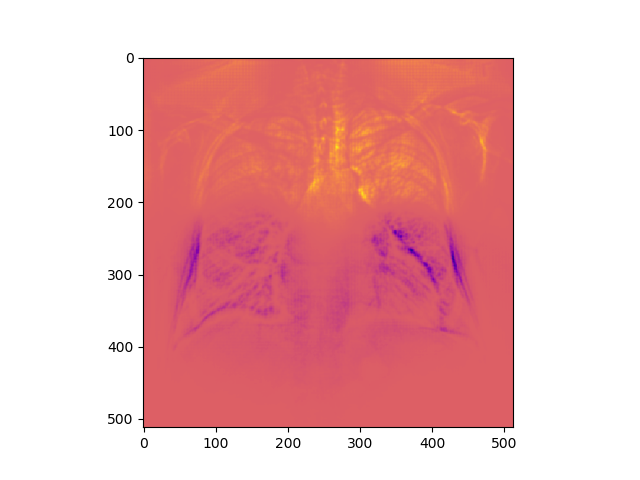

In [53]:
%matplotlib notebook

plot_interpretation(lrp_b_flat_img_error)

In [54]:
analyzer = create_analyzer("pattern.net", model_without_softmax)
analyzer.fit(X_train, batch_size=1)
patter_net_img_error = analyzer.analyze(x_error)

<IPython.core.display.Javascript object>


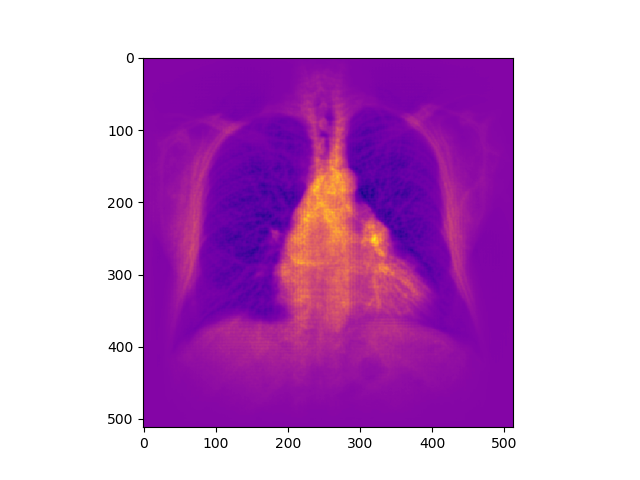

In [55]:
%matplotlib notebook

plot_interpretation(patter_net_img_error)

### New Subset of Data
Use interpretability methods to find unwanted bias in the data. 

Consider a new subset of the Chest X-Ray data: 

In [3]:
with open("NIH_Data/X_400_bias.pickle",'rb') as fp: 
        X = pickle.load(fp)
X = np.array(X, dtype='float') 

X = np.reshape(X, (-1, 512, 512, 1))
X = np.concatenate([X, X, X], axis=3)
print('Shape of X: ', X.shape)

X = preprocess_input(X) # pre-process for VGG16
print('X max: ', np.max(X))

with open("NIH_Data/y_400_bias.pickle",'rb') as fp: 
        y = pickle.load(fp)
y = np.array(y)

print('Shape of y: ', y.shape)
labels = to_categorical(y)

Shape of X:  (400, 512, 512, 3)
X max:  151.061
Shape of y:  (400,)


Split data into training and validation:

In [4]:
sk = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_idx, validation_idx in sk.split(X, y): 
    X_train, X_validation = X[train_idx], X[validation_idx]
    y_train, y_validation = labels[train_idx], labels[validation_idx]

You can build your own model to **detect Cardiomegaly in this new subset of the data**. However, there is a model already trained that you can use if you are not comfortable with keras and/or deep learning.

In [5]:
model = load_model('Models/NIH_bias_new.hdf5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_for_chest (InputLayer) (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

Evaluate model performance: 

In [6]:
label = np.argmax(y_train, axis=1)

pred = model.predict(X_train, batch_size=1)
pred = np.argmax(pred, axis=1)

print(accuracy_score(label, pred))

1.0


Investigate the model and check if the model is behaving as it was expected. 

In [7]:
index = 0 

label = np.argmax(y_train, axis=1)

for i in range(X_train.shape[0]): 
    if(label[i]==1 and pred[i]==1): 
        index = i
        break

In [8]:
x = X_train[index]
x = np.reshape(x, (1, 512, 512, 3))

In [9]:
model_without_softmax = model_wo_softmax(model)

In [10]:
analyzer = create_analyzer("guided_backprop", model_without_softmax) 
guided_backprop_img_bias = analyzer.analyze(x)

<IPython.core.display.Javascript object>


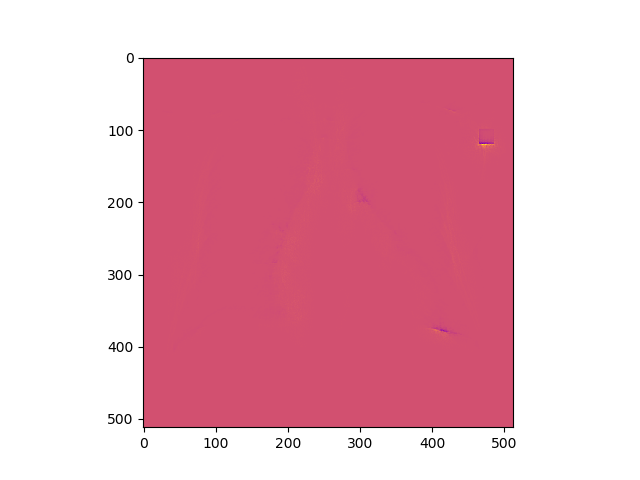

In [13]:
%matplotlib notebook

plot_interpretation(guided_backprop_img_bias)

In [14]:
analyzer = create_analyzer("lrp.sequential_preset_b_flat", model_without_softmax) 
lrp_b_flat_img_bias = analyzer.analyze(x)

<IPython.core.display.Javascript object>


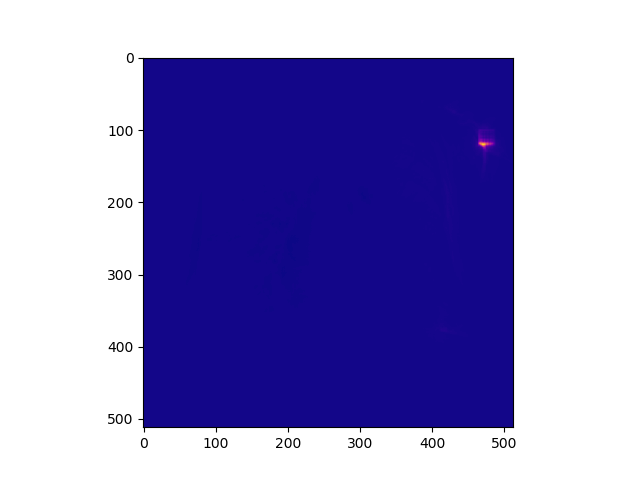

In [16]:
%matplotlib notebook

plot_interpretation(lrp_b_flat_img_bias)

In [17]:
index = 0 

label = np.argmax(y_train, axis=1)

for i in range(X_train.shape[0]): 
    if(label[i]==0 and pred[i]==0): 
        index = i
        break

In [18]:
x = X_train[index]
x = np.reshape(x, (1, 512, 512, 3))

In [19]:
analyzer = create_analyzer("lrp.sequential_preset_b_flat", model_without_softmax) 
img = analyzer.analyze(x)

<IPython.core.display.Javascript object>


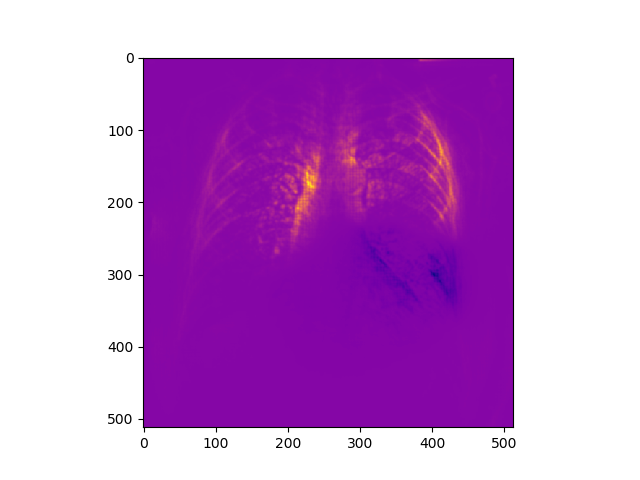

In [20]:
%matplotlib notebook

plot_interpretation(img)